# Importing Packages

In [58]:
import numpy as np
import pandas as pd
import json

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.quantization
import torchvision

# Loading Model and Quantizing

In [59]:
import torchvision
quantized_model = torchvision.models.quantization.mobilenet_v2(weights="DEFAULT", quantize=True)

/home/adam-taback/miniconda3/envs/fbgemm/lib/python3.12/site-packages/torch/ao/quantization/utils.py:339: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(


# Functions to Get Activations

In [60]:
# Function to capture intermediate outputs and prepare for quantization
def get_intermediate_outputs(model, input_data):
    intermediate_outputs = []

    def hook_fn(module, input, output):
        intermediate_outputs.append(input)
        intermediate_outputs.append(output)

    hooks = []
    for layer in model.children():
        hook = layer.register_forward_hook(hook_fn)
        hooks.append(hook)

    # Forward pass
    with torch.no_grad():
        model(input_data)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    return intermediate_outputs

# Quantize and save all tensors
def save_tensor_as_list(tensor, filename):
    tensor_list = tensor.cpu().numpy().tolist()  # Convert tensor to list
    with open(filename, 'w') as f:
        json.dump(tensor_list, f)
        
# save tensors as numpy files
def save_tensor_as_npy(tensor, filename):
    tensor_list = tensor.cpu().numpy()  # Convert tensor to list
    np.save(filename, tensor_list)

In [61]:
class CompTensor:
    def __init__(self, tensor):
        self.tensor = tensor
        self.shape = tensor.shape
        self.flat = tensor.flatten()

    def update_tensor(self):
        # update tensor with new values from self.flatten
        self.tensor = self.flatten.reshape(self.shape)
        
    def update_flatten(self):
        # update flatten with new values from self.tensor
        self.flat = self.tensor.flatten()
        
    def to(self, type):
        self.tensor = self.tensor.to(type)
        self.update_flatten()
        
        return self

# Generate Traces

In [62]:
# Define an input tensor with appropriate shape
input_tensors = [torch.randn(1, 3, 224, 224) for i in range(9)]  # For a single image of size 224x224 with 3 channels (RGB)

# Capture intermediate outputs
intermediate_outputs = []
for data in input_tensors:
    intermediate_outputs.append(get_intermediate_outputs(quantized_model, data))
    
# group tensors by layer
layerwise_tensors = {}
for i in range(len(intermediate_outputs)):
    for j in range(1,len(intermediate_outputs[i])-1): # only consider intermediate tensors (skip input and output)
        if j not in layerwise_tensors:
            layerwise_tensors[j] = []
        layerwise_tensors[j].append(intermediate_outputs[i][j][0].int_repr())

# convert lists to tensors
for j in layerwise_tensors:
    layerwise_tensors[j] = torch.stack(layerwise_tensors[j])
    
# print tensors
for j in layerwise_tensors:
    print(j, layerwise_tensors[j].shape)
    
    
# Get unique values for each layer
unique_layerwise_tensors = {}
for j in layerwise_tensors:
    unique_layerwise_tensors[j] = torch.unique(layerwise_tensors[j].flatten())

print("Unique values per layer:")
for key, value in unique_layerwise_tensors.items():
    print(f"Layer {key}:")
    print(value)

1 torch.Size([9, 3, 224, 224])
2 torch.Size([9, 1, 3, 224, 224])
3 torch.Size([9, 1280, 7, 7])
4 torch.Size([9, 1, 1280])
5 torch.Size([9, 1000])
6 torch.Size([9, 1, 1000])
Unique values per layer:
Layer 1:
tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 

In [63]:
# flatten layerwise tensors
flatten_layerwise_tensors = []

for key in layerwise_tensors:
    flatten_layerwise_tensors.append(CompTensor((layerwise_tensors[key]).flatten()))

In [64]:
flatten_layerwise_tensors[0].tensor
layerwise_tensors.keys(), len(flatten_layerwise_tensors)

(dict_keys([1, 2, 3, 4, 5, 6]), 6)

In [65]:
# save all tensors as numpy files
d = "trace/mobilenet_v3/"
for i in range(1, len(flatten_layerwise_tensors) + 1):
    save_tensor_as_npy(flatten_layerwise_tensors[i - 1].to(torch.uint8).tensor, d + "input_" + str(i) + "_flat.npy")
    
for i in range(1,len(layerwise_tensors) + 1):
    save_tensor_as_npy(layerwise_tensors[i].to(torch.uint8), d + "input_" + str(i) + ".npy")

# Generating Symbol Tables for Traces

In [66]:
# run atalanta_numpy.py on the saved numpy files to get the symbol tables
import subprocess
import os

e_size = 8 # number of bits per element

for i in range(1, 7):

    print("Running Atalanta on input_" + str(i) + "_flat.npy")
    
    # define file to get trace from
    trace = "trace/mobilenet_v3/" + "input_" + str(i) + "_flat.npy"

    # define command
    command = ["python3", "atalanta/atalanta_numpy.py", trace, str(e_size)]
    
    # Run the command
    result = subprocess.run(command, capture_output=True, text=True)

    # Print the output and error (if any)
    # print("\tOutput:")
    # print("\t", result.stdout)

    print("\tError:")
    print("\t",result.stderr)

Running Atalanta on input_1_flat.npy
	Error:
	 PT_INIT: [0, 4 (45014)] [16, 4 (39070)] [32, 4 (61742)] [48, 4 (88885)] [64, 4 (117732)] [80, 4 (141897)] [96, 4 (157778)] [112, 4 (160082)] [128, 4 (148477)] [144, 4 (126017)] [160, 4 (98109)] [176, 4 (69438)] [192, 4 (45629)] [208, 4 (27219)] [224, 4 (14781)] [240, 4 (12882)] [256, 0 (0)] 
PTBEST: PT_INIT: [0, 2 (26894)] [4, 5 (57190)] [32, 4 (61742)] [48, 4 (88885)] [64, 4 (117732)] [80, 4 (141897)] [96, 4 (157778)] [112, 4 (160082)] [128, 4 (148477)] [144, 4 (126017)] [160, 4 (98109)] [176, 4 (69438)] [192, 4 (45629)] [208, 4 (27219)] [224, 4 (14781)] [240, 4 (12882)] [256, 0 (0)] 
PTBEST: PT_INIT: [0, 1 (24540)] [2, 5 (59544)] [32, 4 (61742)] [48, 4 (88885)] [64, 4 (117732)] [80, 4 (141897)] [96, 4 (157778)] [112, 4 (160082)] [128, 4 (148477)] [144, 4 (126017)] [160, 4 (98109)] [176, 4 (69438)] [192, 4 (45629)] [208, 4 (27219)] [224, 4 (14781)] [240, 4 (12882)] [256, 0 (0)] 
PTBEST: PT_INIT: [0, 0 (23397)] [1, 5 (60687)] [32, 4 (61742

In [76]:
for i in range(1, 7):
    print(layerwise_tensors[i].flatten().shape)

torch.Size([1354752])
torch.Size([1354752])
torch.Size([564480])
torch.Size([11520])
torch.Size([9000])
torch.Size([9000])


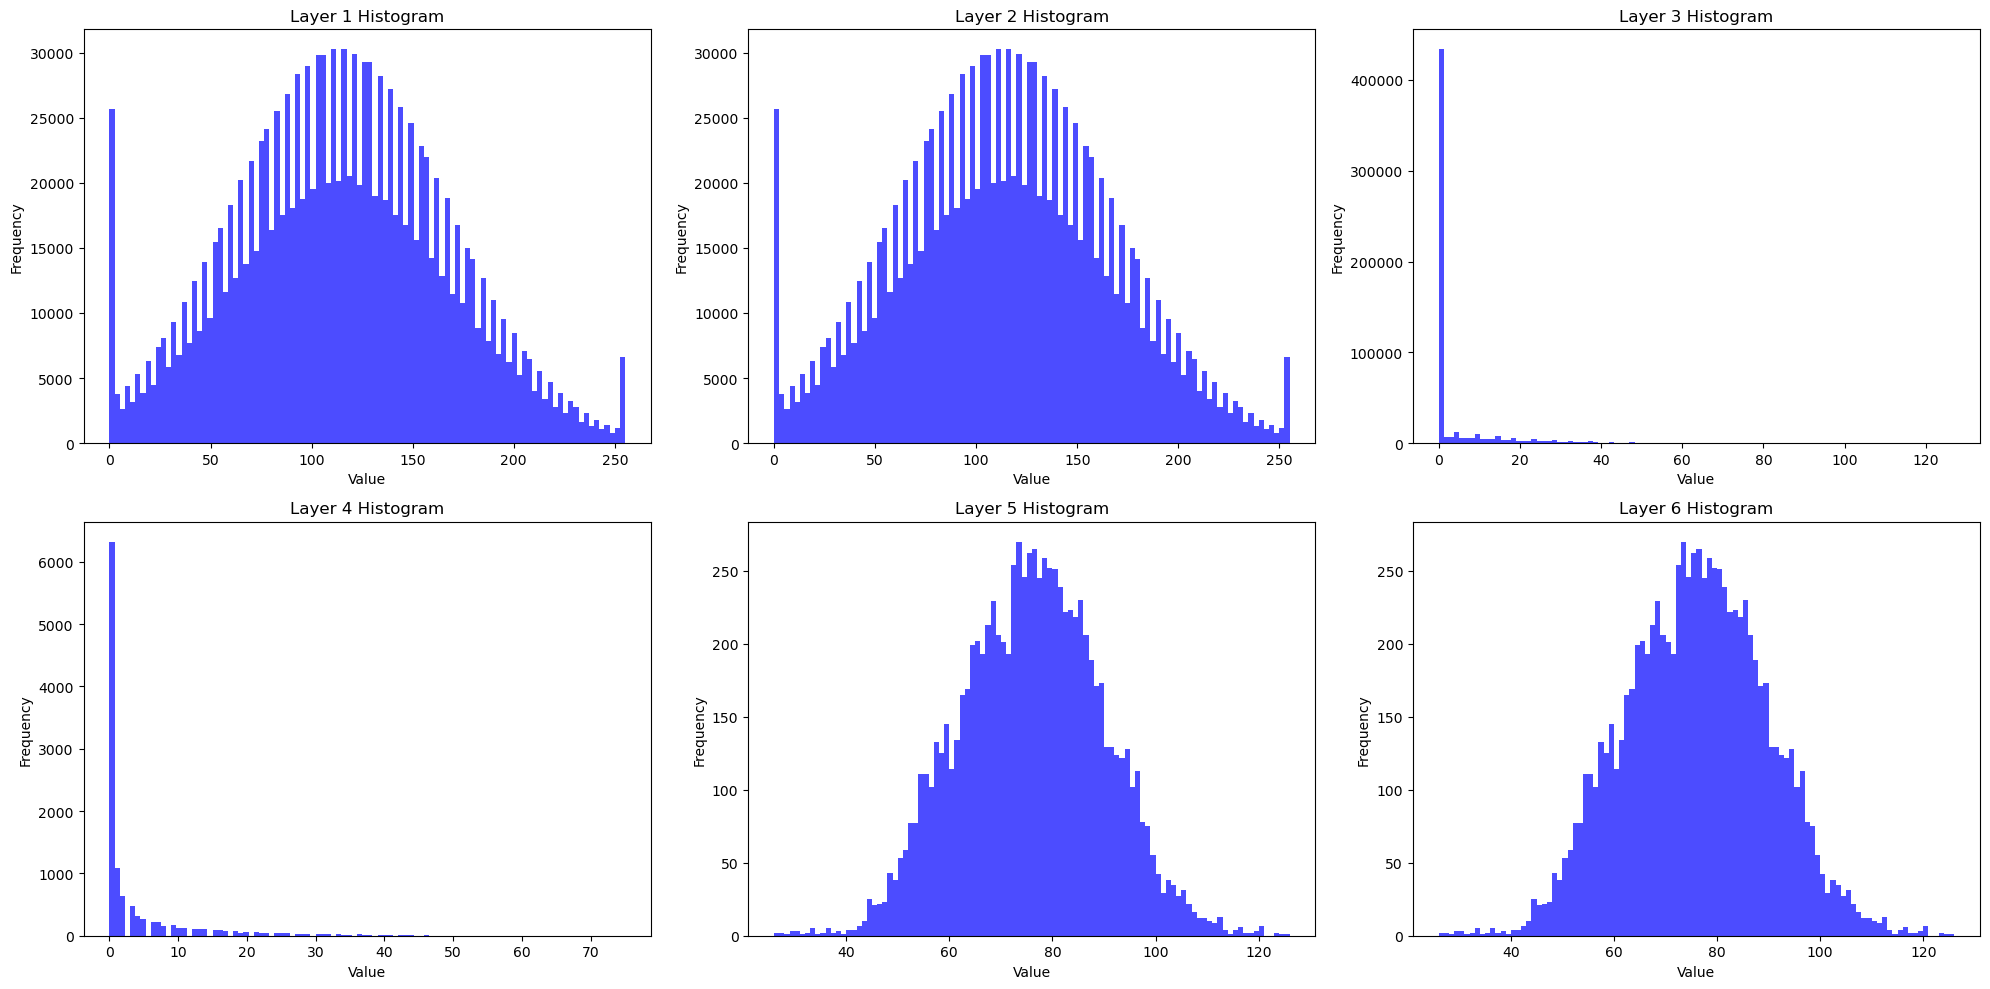

In [67]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 10))  # 2 rows and 4 columns

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot histograms for each layer
for i in range(6):
    temp = flatten_layerwise_tensors[i]
    
    # Plot temp as histogram
    axes[i].hist(temp.flat.cpu().numpy(), bins=100, color='blue', alpha=0.7)
    axes[i].set_title(f"Layer {i+1} Histogram")
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


# Generating Symbol Table

In [68]:
# Take the first tensor and prep the symbols
inp = all_tensors[2]

# get a histogram of the tensor
n_buckets = 2**8
hist, bin_edges = np.histogram(inp.flat, bins=n_buckets)

# plot the histogram
import matplotlib.pyplot as plt
plt.plot(hist)
plt.show()

NameError: name 'all_tensors' is not defined

In [ ]:
# Create symbol table with equal distribution
n_symbols = 2**8

sym_table = np.linspace(min(inp.flat), max(inp.flat), n_symbols)
sym_table = np.column_stack((sym_table,hist))

In [ ]:
sym_table

array([[-4.47050238e+00,  1.00000000e+00],
       [-4.43382203e+00,  0.00000000e+00],
       [-4.39714168e+00,  0.00000000e+00],
       [-4.36046134e+00,  0.00000000e+00],
       [-4.32378099e+00,  0.00000000e+00],
       [-4.28710064e+00,  0.00000000e+00],
       [-4.25042030e+00,  0.00000000e+00],
       [-4.21373995e+00,  1.00000000e+00],
       [-4.17705960e+00,  0.00000000e+00],
       [-4.14037925e+00,  0.00000000e+00],
       [-4.10369891e+00,  1.00000000e+00],
       [-4.06701856e+00,  1.00000000e+00],
       [-4.03033821e+00,  0.00000000e+00],
       [-3.99365787e+00,  2.00000000e+00],
       [-3.95697752e+00,  0.00000000e+00],
       [-3.92029717e+00,  0.00000000e+00],
       [-3.88361683e+00,  0.00000000e+00],
       [-3.84693648e+00,  0.00000000e+00],
       [-3.81025613e+00,  1.00000000e+00],
       [-3.77357579e+00,  2.00000000e+00],
       [-3.73689544e+00,  1.00000000e+00],
       [-3.70021509e+00,  2.00000000e+00],
       [-3.66353475e+00,  4.00000000e+00],
       [-3.

In [ ]:
from scipy.stats import entropy
# calculate current size of table using entropy
def calculate_entropy(data):
    """
    Calculate the entropy of a dataset.
    
    Parameters:
        data (list or np.array or pd.Series): The input data (categorical or discrete values).
    
    Returns:
        float: The calculated entropy.
    """
    if isinstance(data, pd.Series):
        value_counts = data.value_counts(normalize=True)
    else:
        value_counts = pd.Series(data).value_counts(normalize=True)
    
    return entropy(value_counts)

In [ ]:
# go through each bin, and calculate the entropy
entropies = []
for i in range(n_buckets):
    # get the indices of the data that are in the bin
    indices = np.where((inp.flat >= bin_edges[i]) & (inp.flat < bin_edges[i+1]))[0]
    
    # calculate the entropy of the data in the bin
    entropies.append(calculate_entropy(inp.flat[indices]))

In [ ]:
sum(entropies)/(2**8)

4.3160160143724955